In [41]:
import pandas as pd
import matplotlib
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

# Data Exploration

### __Read data to create dataframes__

In [2]:
brands = pd.read_csv('brands.csv')
orderlines = pd.read_csv('orderlines.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')

og_brands = pd.read_csv('brands.csv')
og_orderlines = pd.read_csv('orderlines.csv')
og_orders = pd.read_csv('orders.csv')
og_products = pd.read_csv('products.csv')

### __Inspect dataframes heads and tails__

In [3]:
# print('###################### BRANDS \n', brands.head(),'\n', brands.tail(),'\n---')
# print('###################### ORDERLINES \n', orderlines.head().to_string(),'\n', orderlines.tail().to_string(),'\n---')
# print('###################### ORDERS \n', orders.head().to_string(), '\n', orders.tail().to_string(),'\n---')
# print('###################### PRODUCTS \n', products.head().to_string(), '\n', products.tail().to_string(),'\n---')

### __Gather some basic descriptives for all the dataframes__

#### brands

In [4]:
# print('\n################################## .describe() \n\n', brands.describe())
# print('\n################################## .isna().any() \n\n', brands.isna().any())
# print('\n################################## .shape \n\n', brands.shape)
# print('\n################################## .columns \n\n', brands.columns)

#### orderlines



In [5]:
# print(orderlines.head().to_string())
# print('\n################################## .describe() \n\n', orderlines.describe())
# print('\n################################## .isna().any() \n\n', orderlines.isna().any())
# print('\n################################## .shape \n\n', orderlines.shape)
# print('\n################################## .columns \n\n', orderlines.columns)

#### orders

In [6]:
# print(orders.head())
# print('\n################################## .describe() \n\n', orders.describe())
# print('\n################################## .isna().any() \n\n', orders.isna().any())
# print('\n################################## .shape \n\n', orders.shape)
# print('\n################################## .columns \n\n', orders.columns)
# print('\n################################## .state.unique() \n\n', orders.state.unique())
# print('\n################################## .order_id.duplicated \n\n', orders.order_id.duplicated().sum())

#### products

In [7]:
# print(products.head().to_string())
# print('\n################################## .describe() \n\n', products.describe())
# print('\n################################## .isna().any() \n\n', products.isna().any())
# print('\n################################## .shape \n\n', products.shape)
# print('\n################################## .columns \n\n', products.columns)

# __Datacleaning__

## Cleaning orders

In [8]:
# Convert datatypes
orders['created_date'] = pd.to_datetime(orders['created_date'])

# Create new columns for 'year' (int), 'month' (int), 'day_of_month' (int), 'weekday' (categorical variable, ordered)
orders['year'] = pd.DatetimeIndex(orders['created_date']).year
orders['month'] = pd.DatetimeIndex(orders['created_date']).month
orders['day_of_month'] = pd.DatetimeIndex(orders['created_date']).day
orders['weekday'] = orders['created_date'].dt.strftime('%A')

# create sorted categories for weekday
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
orders['weekday'] = pd.Categorical(orders['weekday'], categories = cats, ordered=True)

# Exclude missing values in total_paid column (cause for missing values is order-state = pending) and check for na before and after manipulation
print(f'Nan-count before removal = {orders.total_paid.isna().sum()}')
orders.dropna(inplace=True)
print(f'Nan-count after removal = {orders.total_paid.isna().sum()}')

Nan-count before removal = 5
Nan-count after removal = 0


## Cleaning orderlines

In [9]:
# Convert datatypes
orderlines['date'] = pd.to_datetime(orderlines['date'])

# rename id_order to order_id to standardize it
orderlines.rename(columns={'id_order':'order_id'}, 
                   inplace=True)

In [10]:
# FIX UNIT_PRICE COLUMN DECIMAL ISSUE
## remove all decimal dots 
orderlines = orderlines.assign(unit_price_nd = orderlines['unit_price'].str.replace('\.','', regex=True))

## separate all numbers before and after the decimal dot
orderlines['integers'] = orderlines['unit_price_nd'].str[:-2]
orderlines['decimals'] = orderlines['unit_price_nd'].str[-2:]

## concatenate integers and decimals with dot in between
orderlines['new_unit_price'] = orderlines['integers'] + '.' + orderlines['decimals']

## create converted unit_price column based on fixed column
orderlines['unit_price'] = pd.to_numeric(orderlines['new_unit_price'])

## drop 'auxiliary' columns
orderlines.drop(['unit_price_nd','decimals','integers','new_unit_price'], axis=1, inplace=True)

# create a new column "total_price" by multiplying product_quantity times unit_price
orderlines['total_price'] = orderlines['product_quantity'] * orderlines['unit_price']

## Cleaning products

### Price and promo Price Columns
* First idea is to remove all rows containing prices that have three digits after the last dot
* For now dropping all na
* Checking the number of rows that have this issue: 
    * price: 537 / 10477 total rows
    * promo_price: 9638 / 10477 total rows

In [16]:
(
products
    .assign(duplicated = lambda df: df[['sku', 'price']].duplicated())
    .query("duplicated == True")
    .head()
)

,sku,name,desc,price,promo_price,in_stock,type,duplicated


In [15]:
# Duplicates
print(f'Duplicates in products: {products.duplicated("sku").sum()}')
# --> 8747
products.drop_duplicates(subset= 'sku', inplace=True)
print(f'Duplicates in products after removal: {products.duplicated("sku").sum()}')

Duplicates in products: 8747
Duplicates in products after removal: 0


### Find "bad" prices and replace with NaN

In [17]:
# Find all "bad" prices
# Replace missing values by '000.000'
products = products.assign(price = products['price'].fillna('000.000'))

# split the price and add a dot count
products = products.assign(price_split = products['price'].str.split('\.'), 
                           dots_count = products['price'].str.count('\.'))

In [18]:
'''
Function to check the price for each row
If price matches the pattern (only 2 digits after the last dot) function will return False, else it will return True 
'''

def check_price(row):
    matcher= re.compile(R'.*\.\d{2}$')
    if matcher.match(row['price']):
        return False
    else:
        return True

'''
Function to check the number of elements in each price_split
Returns an integer representing that number
'''

def check_len_price_split(row):
    return len(row['price_split'])

# create new column 'need_check' with False if last element of price consists of only 2 digits, and True if it's more than 2
products = (
            products
                .assign(
                    need_check = products.apply(lambda row: check_price(row), axis=1),
                    len_price_split = products.apply(lambda row: check_len_price_split(row), axis=1))
            )

In [19]:
# replace all faulty prices that fulfill three conditions with NaN
# conditions: 
# 1. more or less than 2 digits after the last dot
# 2. more than one element in column price_split
# 3. number of dots in price is different than 0

products.loc[(products.need_check==True) & (products.len_price_split > 1) & (products.dots_count != 0), 'price'] = 'Null'

# convert price to float and coerce errors
products['price'] = pd.to_numeric(products['price'], errors='coerce')

# remove now unnecessary columns
products.drop(['price_split','need_check','len_price_split','dots_count'], axis=1, inplace=True)

### Fill missing prices

In [20]:
# check impact of missing values in price column
# create df containing only rows with missing values in products df 
prod_na = products.loc[products.isna().sum(axis=1) > 0,:].copy()

# create list of skus that have missing price in products df
na_skus = prod_na['sku'].tolist()

# check how much of the revenue of total completed orders is associated with skus that have missing prices 
(
orderlines
    .merge(orders, how='left', on ='order_id')
    .query('state == "Completed" & sku == @na_skus')
    ['total_price'].sum()
) / (
orderlines
    .merge(orders, how='left', on='order_id')
    .query('state == "Completed"')
    ['total_price'].sum()
)

0.05782122836856714

In [21]:
# find out which sku are missing in products
prod_na_list = (
products
    .loc[products['price'].isna(),'sku']
    .tolist()
)

# find them on orderlines, and aggregate the information to find the maximum value
orderlines_prod_na_max = (
orderlines
    .query("sku == @prod_na_list")
    .groupby('sku') 
    .agg(max_price_orderlines = ('unit_price', max))
    .reset_index()
)

# add max_price_orderlines to the products df
products = (
products
    .merge(orderlines_prod_na_max, how='left',on='sku')
)


In [22]:
# replace missing values in price with orderlines_max_price
products = (
products
    .assign(
        price = lambda df_: np.where(np.isnan(df_['price']), df_['max_price_orderlines'], df_['price'])
        )
 )

# remove max_price_orderlines column
products.drop('max_price_orderlines', axis=1, inplace=True)

### Promo price

In [23]:
# Remove all dots from promo_prices and add one dot before the second to last digit, then convert to numeric
products = (
    products
        .assign(promo_price = lambda df: df['promo_price'].str.replace('.', ''))
        .assign(promo_price = lambda df: df['promo_price'].str[:-2] + '.' + df['promo_price'].str[-2:])
        .dropna(subset = 'promo_price')
        .assign(promo_price = lambda df: pd.to_numeric(df['promo_price']))
)

C:\Users\tobia\AppData\Local\Temp\ipykernel_16616\2699542818.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  .assign(promo_price = lambda df: df['promo_price'].str.replace('.', ''))


In [25]:
# Function to reduce promo_price
# While promo_price is higher than price, divides by 10 to move decimal point one further to the left
# Returns the result of the divisions once promo price is smaller than price
def reduce_promo_price(row):
  result = round(row['promo_price'], 2) 
  while result > row['price']:
    result = round((result / 10), 2)
  return result

products['promo_price'] = products.apply(lambda row : reduce_promo_price(row), axis=1)

In [26]:
# Check promo_prices for issues
products.sample(20)

,sku,name,desc,price,promo_price,in_stock,type
8012,APP2106,Apple Correa 42mm Sports Blue Haze,Durable and flexible strap sports with clip cl...,59.00,0.56,0,2449
2341,AII0085,Aiino Glass Screen Protector Edge to Edge Temp...,Screen saver superfine glass covers the entire...,24.99,19.99,0,13555403
1883,MOP0061,Mophie Juice Pack Air Case Battery (2750 mAh) ...,Case 2750 mAh battery and LED indicator for iP...,109.99,51.99,0,"5,49E+11"
9089,PAC2322,Synology DS718 + NAS Server | 2GB RAM | 20TB (...,Scalable NAS server with transcoding 4K: 4-cor...,1259.97,1009.18,0,12175397
1654,MOS0141,Moshi iGlaze iPhone 6 / 6S Plus Black,Rigid shell shock protection and rasguÌ ± os f...,35.00,24.99,0,11865403
10366,APP2619,Apple Correa Deportiva 42mm Gray,Durable and flexible strap sports with clip cl...,59.00,57.00,0,2449
4641,WDT0231-A,Open - Western Digital Elements 2TB USB 3.0 Ha...,2TB Portable External Hard Drive for Mac and PC,105.00,94.16,0,1298
7104,SXA0029,SecurityXtra One Desktop Security Support iPad...,Safety support fixed viewing angle of 45 degre...,189.99,1.39,0,1216
3094,TIG0018-A,Open - Tigra Support + Bike Case iPhone 6,Waterproof Case for iPhone 6 bicycle stand,39.99,28.25,0,1298
1599,MOB0013,Mobee Magic Feet Charger Apple Wireless Keyboa...,Charger for Apple Wireless Keyboard and Magic ...,149.99,149.99,0,13005399


In [21]:
# TESTING

# (
# products
#     .merge((og_products
#                 .rename(columns={'price': 'og_price', 'promo_price': 'og_promo_price'})
#                 [['sku', 'og_price', 'og_promo_price']]), 
#             how='left', on='sku')
#     [['sku', 'name', 'price', 'og_price', 'promo_price', 'og_promo_price']]
#     .sample(15)
# )

## Cleaning brands

In [22]:
# No cleaning needed, everything is fine here

# Data-Consistency Checks

## Dates between orders and orderlines

In [27]:
# Check whether dates of first and last orders match in orders vs orderlines

min_date_orders=min(orders['created_date'])
max_date_orders= max(orders['created_date'])
min_date_orderlines = min(orderlines['date'])
max_date_orderlines = max(orderlines['date'])

pd.DataFrame(
    {
        'df': ['orders', 'orderlines'],
        'first_order': [min_date_orders, min_date_orderlines],
        'last_order': [max_date_orders, max_date_orderlines]
    })

,df,first_order,last_order
0,orders,2017-01-01 00:07:19,2018-03-14 13:58:36
1,orderlines,2017-01-01 00:07:19,2018-03-14 13:58:36


## Total price between orders and orderlines

In [30]:
# Exploration of price mismatch from perspective of ORDERLINES

print(f'Total price sum in orders=     {orders.total_paid.sum()}\nTotal price sum in orderlines= {orderlines.total_price.sum()}\n')

# Exploration of price mismatch from perspective of ORDERLINES
## create copy of orderlines with column checking whether order id is also in orders df
ol_copy = orderlines.assign(check_orders = orderlines['order_id'].isin(orders['order_id'])).copy()

# check unequal rows
print(
ol_copy
    .query("check_orders==False")
)
print()

# there are 240 rows of orders that are not in the orders df - these will be removed for now
orderlines = (ol_copy
              .query("check_orders==True").copy())

Total price sum in orders=     129159615.07000001
Total price sum in orderlines= 128776222.02999999

             id  order_id  product_id  product_quantity      sku  unit_price  \
5       1119114    295310           0                10  WDT0249      231.79   
63      1119218    296284           0                 1  BNQ0042      699.00   
67      1119223    294806           0                 1  APP1849     2558.99   
69      1119226    294806           0                 1  APP1864     2797.99   
70      1119235    297261           0                 1  QNA0177      304.99   
...         ...       ...         ...               ...      ...         ...   
275665  1621177    244328           0                 1  OWC0260      349.00   
280055  1628699    261391           0                 1  APP2352     3343.00   
280352  1629247    287797           0                 1  SYN0182      484.11   
280856  1630150    261391           0                 1  SAT0091       44.99   
280869  1630178    

In [32]:
# Exploration of price mismatch from perspective of ORDERS
# check whether order id is also in orderlines df
(
orders
 .assign(check_orders = orders['order_id'].isin(orderlines['order_id']))
 .query("check_orders==False")
)

,order_id,created_date,total_paid,state,year,month,day_of_month,weekday,check_orders


In [33]:
# check state of orders that are in orders but not in orderlines
(
orders
    .assign(check_orders = orders['order_id'].isin(orderlines['order_id']))
    .query("check_orders==False")
    ['state'].value_counts()
)

Series([], Name: state, dtype: int64)

In [34]:
# Can be explored further, but for now all unmatched orders will be dropped
orders = (orders
            .assign(check_orders = orders['order_id'].isin(orderlines['order_id']))
            .query("check_orders==True")
         )

In [35]:
# Merge orderlines and order to check price-differences
ol_orders_merged = (
    orderlines
        .groupby('order_id')
        .agg({'total_price':'sum'})
        .merge(orders, how='left', on='order_id')
        .rename(columns= {
            'total_price':'total_price_orderlines',
            'total_paid': 'total_paid_orders'
        })
        .copy()
)

In [36]:
# create price-difference column and remove small differences
def get_price_difference(row):
    if (abs(row['total_price_orderlines'] - row['total_paid_orders']) <= 0.1):
        result = 0
    else:
        result = (row['total_price_orderlines'] - row['total_paid_orders'])
    return abs(round(result,2))

ol_orders_merged['price_diff'] = ol_orders_merged.apply(lambda row : get_price_difference(row), axis=1)

In [37]:
# Explore price differences
(
ol_orders_merged
    .query("price_diff != 0")
    ['price_diff']
    .value_counts()
    .head(25)
)

6.99     16729
4.99     15881
3.99     10287
19.99     1239
9.99       972
5.00       632
7.00       451
11.99      246
4.00       129
1.01       124
6.98       100
14.99       86
1.99        84
4.98        72
19.98       62
20.00       57
10.00       42
7.01        33
3.98        28
20.01       15
9.98        10
14.98       10
21.01        8
10.01        7
12.99        7
Name: price_diff, dtype: int64

### Insights on price-differences

* price differences probably come from shipping costs
* price differences that were less than +- 10 cents were set to 0 to clean the dataset 
* recommendation: no need to remove any rows, because the remaining rows all contain plausible and explainable price-differences

# Export of orders and orderlines

In [28]:
orderlines.to_csv(R'C:\Users\tobia\Documents\Bootcamp\03_datacleaning_storytelling_pd_matplot\00_eniac_data\cleaned_data\orderlines_cleaned.csv', index=False)
orders.to_csv(R'C:\Users\tobia\Documents\Bootcamp\03_datacleaning_storytelling_pd_matplot\00_eniac_data\cleaned_data\orders_cleaned.csv', index=False)

# __Exploration of specific questions__

## Suggested Questions

__How many orders are there?__  
226909 unique order_ids.  
  
__How many products are there?__  
10579 unique products  

__Which timespan is captured in the dataset?__  
First order in dataset made on: 2017-01-01 00:07:19  
Last order in dataset made on: 2018-03-14 13:58:36

__How many orders are completed?__  
46605 orders are completed.  
  
__How should revenue be computed?__  
Summarize price of all unique orders with state = completed.  
Total revenue from captured data: 15907059.89 €



In [38]:
# num of orders
orders.order_id.nunique()
# num of products
products.sku.nunique()

# timeperiod captured
first_order = orders.created_date.min()
last_order = orders.created_date.max()
print(f'First order in dataset made on: {first_order}\nLast order in dataset made on: {last_order}')

# num of completed orders
orders.loc[orders['state'] == 'Completed','order_id'].count()

# revenue
print(f"Total revenue (sum of total_paid of orders where state = completed) = {orders.loc[orders['state'] == 'Completed','total_paid'].sum()}")

First order in dataset made on: 2017-01-01 00:07:19
Last order in dataset made on: 2018-03-14 13:58:36
Total revenue (sum of total_paid of orders where state = completed) = 15907059.889999995


## Revenue  
  
__Monthly Revenue__:  


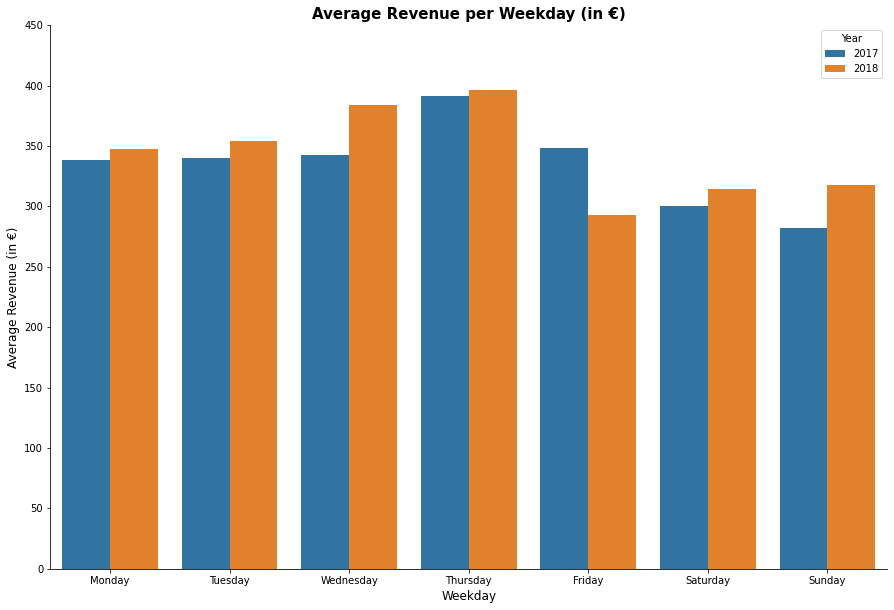

In [87]:
rev_by_day = pd.DataFrame(
    orders
    .loc[orders['state'] == 'Completed', 'total_paid']
    .groupby([orders['weekday'], orders['year']])
    .mean()
    .reset_index()
)


rev_by_day['weekday_cat'] = pd.Categorical(
    rev_by_day['weekday'],
    categories=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    ordered = True
)
rev_by_day = rev_by_day.sort_values('weekday_cat')
rev_by_day.drop(columns = 'weekday', inplace=True)

# rev_by_day.plot.bar(x = 'weekday_cat')

plt.subplots(figsize=(15, 10))

sns.barplot(
    data = rev_by_day,
    x = 'weekday_cat',
    y = 'total_paid',
    hue = 'year'
)
plt.ylim(0 , 450)
plt.xlabel('Weekday', fontsize=12)
plt.ylabel('Average Revenue (in €)', fontsize=12)
plt.title('Average Revenue per Weekday (in €)', weight='bold', fontsize=15)
plt.legend(title= 'Year')
sns.despine() 
plt.show()
